# Answers

You can edit this Jupyter notebook to include your answers and run any code that generates those answers or produces plots.  You can add additional cells for code or markdown as needed.

This homework is primarily about running simulations involving initial value problems (IVPs)

## Problem 0 (45 points)

In this problem, you'll implement a custom ODE solver for `solve_ivp` based on the Forward Euler method, and implement some basic tests.

### Part A (20 points)
If you read the [documentation for `solve_ipv`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html), which we used in class, you'll see that you can write your own solver.

Write a solver for the forward Euler method, which is not implemented as one of the available solvers (while simple, it typically is not very accurate).  Recall, this is the basic rule:
\begin{equation}
y(t + h) = y(t) + h f(t, y)
\end{equation}

Your solver should be a class which is derived from [`scipy.integrate.OdeSolver`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.OdeSolver.html#scipy.integrate.OdeSolver)
```python
class ForwardEuler(scipy.integrate.OdeSolver):
    pass
```

Your class definition should go in [`euler.py`](euler.py)

You should read the documentation for this base class in order to implement `ForwardEuler`.  Here are some hints/notes:
* Allow a user to set `h` using a keyword argument.  This can be passed using `solve_ivp(..., method=ForwardEuler, h=0.01)` to set `h=0.01`
* Use a default step size `h = (t_bound - t0) / 100`
* private methods begin with an underscore "_"
* the method `_dense_output_impl(self)` should output a `ForwardEulerOutput` (defined in [`euler.py`](euler.py))
* direction should be `+1`
* You won't use a Jacobian, so `njev` and `nlu` can remain at 0.
* You may want to consider using `super(ForwardEuler, self).__init__`
* You may want to read the source code for the parent class [here](https://github.com/scipy/scipy/blob/v1.5.3/scipy/integrate/_ivp/base.py#L25-L214)

---

*put any discussion here*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from euler import ForwardEuler

### Part B (10 points)

Use your `ForwardEuler` solver and `solve_ivp` to solve an IVP $y'(t) = y$ with $y(0) = 1$ on the domain $t\in [0,5]$, using a step size `h=0.01`.  Make a plot of the solution to this IVP with axes labeled `y` and `x`.

Use SymPy to obtain the ground-truth solution to this IVP.  What is the largest error you see on the domain you solved the problem?  Try solving with the default solver in `solve_ivp`.  What is the largest error in this case?

---

*put your answers here*

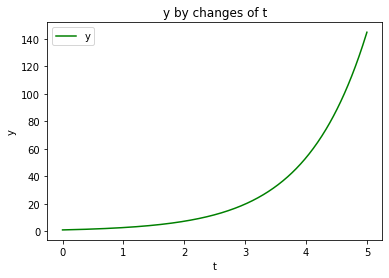

The largest error for Euler is: 3.64038667000352
The largest error for default is: 0.0587094595572921
Euler max error happened at t equals to: 5.0 sec.
default max error happened at t equals to: 4.58 sec.
The ground truth solution is shown on the output chunk.


Eq(y(t), exp(t))

In [2]:
import sympy as sym
import math
from sympy.solvers import ode

# First, specify the initial conditions and the ODE that we are considering
v0 = np.array([1])
f = lambda t, v: v

# Specify the time span and the number of points that are being evaluated
t_span = (0,5)
t_actual = np.linspace(0,5,501)
t_eval = np.linspace(0,5,501)

# Solve and plot
sol = solve_ivp(f, t_span, v0, method = ForwardEuler, h=0.01)
plt.plot(sol.t, sol.y[0], label="y", c='g')
plt.title("y by changes of t")
plt.ylabel("y")
plt.xlabel("t")
plt.legend()
plt.show()
sol2 = solve_ivp(f, t_span, v0, t_eval=t_eval)
# Get the ground truth solution and compare with the solutions from Euler Forward method

y, t = sym.symbols('y t') # symbol
y = sym.Function('y') # symbolic function
eqn = y(t).diff(t) - y(t) # eqn = 0
f = ode.dsolve(eqn, hint='separable', ics={y(0): 1})
error_lst = []
err_2_lst = []
tru_sol = sol.y[0]
sol_2 = sol2.y[0]

# Recording errors
for t_spot in t_actual:
    p = list(t_actual).index(t_spot)
    error_lst.append(np.abs(f.rhs.evalf(subs={t: t_spot})-tru_sol[p]))
    err_2_lst.append(np.abs(f.rhs.evalf(subs={t: t_spot})-sol_2[p]))
print("The largest error for Euler is: " + str(max(error_lst)))
print("The largest error for default is: " + str(max(err_2_lst)))
ind = error_lst.index(max(error_lst))
ind2 = err_2_lst.index(max(err_2_lst))
print("Euler max error happened at t equals to: " + str(t_actual[ind]) + " sec.")
print("default max error happened at t equals to: " + str(t_actual[ind2]) + " sec.")
print("The ground truth solution is shown on the output chunk.")
f

### Part C (15 points)

Implement unit tests that verify that ODE solutions (numerically) obey the ODE.  Try this for $y'(t) = y$, with $y(0) = 1$ on the domain $t\in [0,5]$.  use a finite difference stencil with step size `k` (`k` should be smaller than the `h` you used to solve the ODE) to compute the derivative at several points.  You should only expect the derivative to be accurate to about `h*y`

Implement tests for `solve_ivp` using the default settings as well as using your `ForwardEuler` implementation.

Put these tests in [`test.py`](test.py).  Set up your unit tests to run when you push changes to GitHub using GitHub actions.

---

*put any discussion here*

## Problem 1 (20 points)

In this problem, you'll solve two simple, but related, ODEs using `solve_ivp`.

### Part A (13 points)

On the surface of the earth, objects are accelerated by a more-or-less constant gravitational field.  We'll consider an object thrown vertically with initial position $y=y_0$, and initial velocity $y' = v_0$.

We'll consider a simplified problem with no wind resistance.  Newton's laws of motion tell us $y''(t) = -g$, where $g = 9.8 m/s^2$.  This is a second order ODE, which we can turn into a system of first order ODEs using the substituion $p = y'$.  Then we have
\begin{equation}
\begin{cases}
y'(t) = p(t)\\
p'(t) = -g
\end{cases}
\end{equation}

You can encode this using a vector $v$, where $v[0]$ is the value $y$ above, and $v[1]$ is $p$.

Use `solve_ivp` to solve for `y(t)` using `y0 = 0` and `y'(0) = 10` (i.e. you throw a ball straight up in the air at a speed of $10 m/s$).  Run this simulation for $4$ seconds.  make a plot of the trajectory $y$ as a function of $t$ (i.e. $t$ is on the horizontal axis and $y$ is on the vertical axis).  Set up an event to end the simulation when `y` is zero again (when the ball hits the ground).  At what time does the ball hit the ground?

Set up an event to find when the ball is at its highest point (`p(t) = 0`).  This should not terminate the simulation.

---

*put any answers/discussion here*

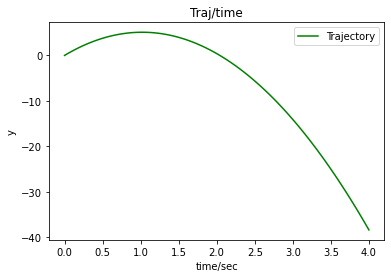

The ball hits the ground at: [2.04081633] sec.


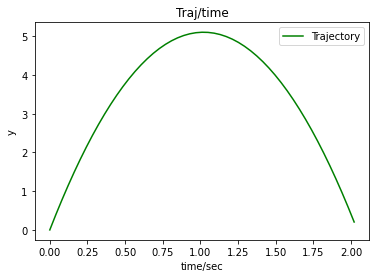

The ball reaches the highest point at: [1.02040816] sec.


In [27]:
# First set up the initial states and constant vals
y0 = 0
p0 = 10
g = 9.8

# Using the way of solving system of ODEs from lecture, specifying the initial conditions
v0 = np.array([y0, p0])
f = lambda t, v : np.array([v[1],-g])

# Specifying time span and intervals
t_span = (0,4)
t_eval = np.linspace(0, 4, 100)

sol = solve_ivp(f, t_span, v0, t_eval=t_eval)
plt.plot(sol.t, sol.y[0], label="Trajectory", c='g')
plt.title("Traj/time")
plt.ylabel("y")
plt.xlabel("time/sec")
plt.legend()
plt.show()

# Define event here, set terminal to True to stopthe simulation

def Traj0(t, y): 
    return y[0] - 0

Traj0.terminal=True
Traj0.direction=-1

sol = solve_ivp(f, t_span, v0, t_eval=t_eval, events=Traj0)
print("The ball hits the ground at: " + str(sol.t_events[0]) + " sec.")
plt.plot(sol.t, sol.y[0], label="Trajectory", c='g')
plt.title("Traj/time")
plt.ylabel("y")
plt.xlabel("time/sec")
plt.legend()
plt.show()

def Highest(t, y): 
    return y[1] - 0
Highest.terminal=False
Highest.direction=-1

sol = solve_ivp(f, t_span, v0, t_eval=t_eval, events=Highest)
print("The ball reaches the highest point at: " + str(sol.t_events[0]) + " sec.")

### Part B (7 points)

We'll now take into account wind resistance on the ball.  We'll make a bunch of assumptions, and simply assume that the drag can be expressed as a force that accelerates the ball by adding a term `y''(t) = p'(t) = -9.8 -0.02 sgn(p(t)) p(t)**2`, where `sgn(p(t))` can be computed using `np.sign` (the sign of the velocity).

Incorporate this term into the system of ODEs, and use `solve_ivp` to plot the trajectory of the ball with the same initial conditions as in part A.  Set up an event to terminate the simulation when the ball hits the ground.  At what time does the ball hit the ground?  Is this before or after the ball hits the ground when there is no wind resistance?

Set up an event to find when the ball is at its highest point (`p(t) = 0`).  This should not terminate the simulation.

---

*put any answers/discussion here*

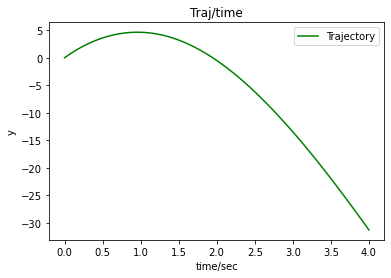

The ball hits the ground at: [1.947363] sec.


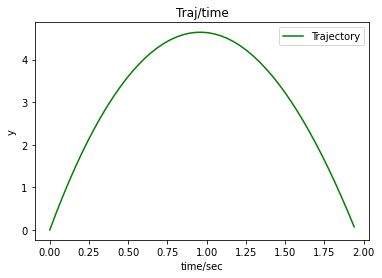

The ball reach highest at: [0.95873405] sec.


In [36]:
# Same initial conditions
y0 = 0
p0 = 10
g = 9.8

# Consider air resistance
v0 = np.array([y0, p0])
f = lambda t, v : np.array([v[1],-g-0.02*np.sign(v[1])*(v[1]**2)])
t_span = (0,4)
t_eval = np.linspace(0, 4, 100)
sol = solve_ivp(f, t_span, v0, t_eval=t_eval)
plt.plot(sol.t, sol.y[0], label="Trajectory", c='g')
plt.title("Traj/time")
plt.ylabel("y")
plt.xlabel("time/sec")
plt.legend()
plt.show()

def Traj0(t, y): 
    return y[0] - 0
Traj0.terminal=True
Traj0.direction=-1
sol = solve_ivp(f, t_span, v0, t_eval=t_eval, events=Traj0)
print("The ball hits the ground at: " + str(sol.t_events[0]) + " sec.")
plt.plot(sol.t, sol.y[0], label="Trajectory", c='g')
plt.title("Traj/time")
plt.ylabel("y")
plt.xlabel("time/sec")
plt.legend()
plt.show()

def Highest(t, y): 
    return y[1] - 0
Highest.terminal=False
Highest.direction=-1
sol = solve_ivp(f, t_span, v0, t_eval=t_eval, events=Highest)
print("The ball reach highest at: " + str(sol.t_events[0]) + " sec.")

## Problem 2 (25 points)

Now that you're warmed up, here are some more simulations.

### Part A (15 points)

In this problem, we'll simulate a planet and moon moving in a 2-dimensional plane.

Newton's law of gravity says that $F_g = Gm_1 m_2 / \|r\|^2$.  The direction of the force is in the direction of the vector $r$.  Let $x(t)$ dentote the position of the planet and $y(t)$ denote the position of the moon, and $r(t) = x(t) - y(t)$ Then
\begin{equation}
x''(t) = -F_g / m_1 \times r / \|r\|\\
y''(t) = F_g / m_2 \times r / \|r\|
\end{equation}
$x$ and $y$ are 2-vectors, so this is a system of 4-second order ODEs.  We can use the trick from problem 1 to write this as 8 first order ODEs by introducing the vector-valued variables
$p(t) = x'(t)$, and $q(t) = y'(t)$.  Here are the terms for $x$:
\begin{equation}
p_1'(t) = -F_g / m_1 \times r_1(t) / \|r\|\\
p_2'(t) = -F_g / m_1 \times r_2(t) / \|r\|\\
x_1'(t) = p_1(t)\\
x_2'(t) = p_2(t)
\end{equation}

We'll model the Earth and moon.  The [Gravitational constant](https://en.wikipedia.org/wiki/Gravitational_constant) has value `G=6.67 e-11` (we're dropping units, which are all SI).  The mass of the earth is `m1 = 5.972 e24`, and the mass of the moon is `m2=0.07346 e24`.  The distance from the moon to the earth is `r = 384.4 e6`.  This means the orbital speed of the moon around the earth is about `1.022 e3`.

Use `solve_ivp` to run a simulation of the moon orbiting the earth for `5 e6` seconds (about 2 months).  Use initial conditions $x(0) = 0, p(0) = 0$ for the earth, and $y(0) = (0, 384.4 \times 10^6)$ and $q(0) = (1.022 \times 10^3, 0)$

Plot $x_1(t), x_2(t)$ and $y_1(t), y_2(t)$ in the same plane with different colors (include a legend and title).

---

*Put any answers/discussion here*

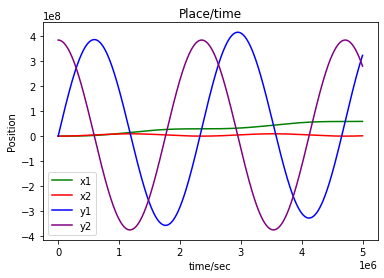

In [37]:
# Implement according to the given information
G = 6.67e-11
r = (3.844e8)**3
m1 = 5.972e24
m2 = 7.346e22
x0 = np.array([0,0])
y0 = np.array([0,3.844e8])
p0 = np.array([0,0])
q0 = np.array([1.022e3,0])
v0 = np.array([x0[0],x0[1],y0[0],y0[1],p0[0],p0[1],q0[0],q0[1]])
f = lambda t, v : np.array([v[4],v[5],v[6],v[7],-G*m2*(v[0]-v[2])/r, -G*m2*(v[1]-v[3])/r, G*m1*(v[0]-v[2])/r, G*m1*(v[1]-v[3])/r])
t_span = (0,5e6)
t_eval = np.linspace(0, 5e6, int(5e6))
sol = solve_ivp(f, t_span, v0, t_eval=t_eval)
plt.plot(sol.t, sol.y[0], label="x1", c='green')
plt.plot(sol.t, sol.y[1], label="x2", c='red')
plt.plot(sol.t, sol.y[2], label="y1", c='blue')
plt.plot(sol.t, sol.y[3], label="y2", c='purple')
plt.title("Place/time")
plt.ylabel("Position")
plt.xlabel("time/sec")
plt.legend()
plt.show()

### Part B (10 points)

The [Lorentz system](https://en.wikipedia.org/wiki/Lorenz_system) is a simplified model of atmospheric convection, which is one of the earliest systems investigated which exhibit [chaotic behavior](https://en.wikipedia.org/wiki/Chaos_theory).

\begin{equation}
\begin{cases}
dx/dt = \sigma( y - x)\\
dy/dt = x( \rho - z) - y\\
dz/dt = xy - \beta z
\end{cases}
\end{equation}

$x$ is the rate of convection, and $y$ and $z$ measure horizontal and vertical temperature variation.

You can use the parameters Lorentz used: $\sigma=10, \beta = 8/3, \rho = 28$.  
Run one simulation starting $x = y = z = 10$.  Run the simulation for $t\in [0,7]$.

Run another simulation starting at $y = z = 10$, and $x = 10.1$.  Run the simulation for $t \in [0,7]$.

Plot both solution trajectories in the $x,y$ plane (i.e. `plt(sol.y[0], sol.y[1],...`) using different colors (include labels, a title, and legend).  This system is chaotic, so the trajectories should start close and then get further apart.

---

*put any answers/discussion here*

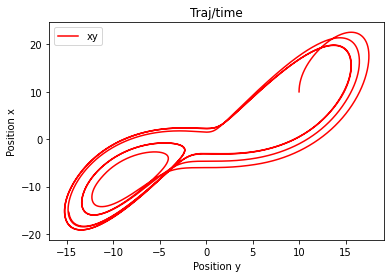

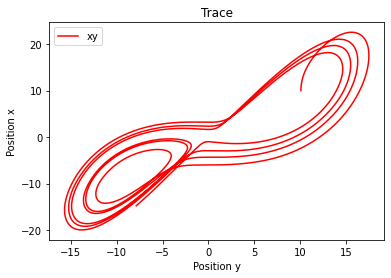

In [41]:
sig = 10
beta = 8/3
rho = 28
# Simulation1
x0 = 10
y0 = 10
z0 = 10
v0 = np.array([x0, y0, z0])
f = lambda t, v : np.array([sig*(v[1]-v[0]), v[0]*(rho-v[2]), v[0]*v[1]-beta*v[2]])
t_span = (0,7)
t_eval = np.linspace(0, 7, 100000)
sol = solve_ivp(f, t_span, v0, t_eval=t_eval)
plt.plot(sol.y[0], sol.y[1], label="xy", c='r')
#plt.plot(sol.y[0], sol.y[2], label="xz", c='red')
#plt.plot(sol.y[1], sol.y[2], label="yz", c='blue')
plt.title("Traj/time")
plt.ylabel("Position x")
plt.xlabel("Position y")
plt.legend()
plt.show()

# Simulation2
x0 = 10.1
v0 = np.array([x0, y0, z0])
f = lambda t, v : np.array([sig*(v[1]-v[0]), v[0]*(rho-v[2]), v[0]*v[1]-beta*v[2]])
t_span = (0,7)
t_eval = np.linspace(0, 7, 100000)
sol = solve_ivp(f, t_span, v0, t_eval=t_eval)
plt.plot(sol.y[0], sol.y[1], label="xy", c='r')
#plt.plot(sol.y[0], sol.y[2], label="xz", c='red')
#plt.plot(sol.y[1], sol.y[2], label="yz", c='blue')
plt.title("Trace")
plt.ylabel("Position x")
plt.xlabel("Position y")
plt.legend()
plt.show()

## Problem 3 (10 points)

Use functionality from `scipy.sparse` to help illustrate your answers to the following questions.

In the [class materials on differentiation](https://caam37830.github.io/book/04_functions/differentiation.html), we defined `forward_diff_matrix` and `backward_diff_matrix`.  What vectors characterize the nullspace of each of these matrices (i.e. vectors `x` so that `D @ x = 0`)?

Give an interpretation (from calculus) of the vector `y` where `y` solves the linear system `D @ y = x`, where `D` is a finite-difference matrix.  What is the implication of the nullspace of `D` on solving this linear system?

Create a finite difference operator for the Laplacian $\Delta = \partial_x^2 + \partial_y^2$ where second-order differences are based on the stencil `[1, -2, 1]`.  What is the nullspace of this matrix?

---

*Your answer here.  You can create some code cells as well*

In [59]:
import scipy.sparse as sparse
import numpy as np
from scipy.linalg import null_space
def forward_diff_matrix(n):
    data = []
    i = []
    j = []
    for k in range(n - 1):
        i.append(k)
        j.append(k)
        data.append(-1)

        i.append(k)
        j.append(k+1)
        data.append(1)
        
    # we'll just set the last entry to 0 to have a square matrix
    return sparse.coo_matrix((data, (i,j)), shape=(n, n)).tocsr()
    
D = forward_diff_matrix(5)
n = np.array([1,1,1,1,1])
D @ n # equals 0
print("Answer: ")
print("The nullspace of forward difference matrix has the basis [1,1,1,...,1]', with respect to size n.")
print("Which is to say, the nullspace consists of all elements with same number on each entry.")
print("")
print("Answer to the second question: ")
print("The solution y may be understood as a pre-image to x under the linear tranformation.")
print("Once we get a solution to the system Dy = x, we have a solution set of y+ay' where y' is in the nullspace of D.")

Answer: 
The nullspace of forward difference matrix has the basis [1,1,1,...,1]', with respect to size n.
Which is to say, the nullspace consists of all elements with same number on each entry.

Answer to the second question: 
The solution y may be understood as a pre-image to x under the linear tranformation.
Once we get a solution to the system Dy = x, we have a solution set of y+ay' where y' is in the nullspace of D.


In [55]:
def forward_diff_matrix(n):
    data = []
    i = []
    j = []
    for k in range(n - 1):
        i.append(k)
        j.append(k)
        data.append(-1)

        i.append(k)
        j.append(k+1)
        data.append(1)
        
    return sparse.coo_matrix((data, (i,j)), shape=(n, n)).tocsr()

def backward_diff_matrix(n):
    data = []
    i = []
    j = []
    for k in range(1,n):
        i.append(k)
        j.append(k)
        data.append(1)

        i.append(k)
        j.append(k-1)
        data.append(-1)
        
    return sparse.coo_matrix((data, (i,j)), shape=(n, n)).tocsr()

def Laplacian_mtx(n):
    D = forward_diff_matrix(n) @ backward_diff_matrix(n)
    Dx = sparse.kron(sparse.eye(n), D).tocsr()
    Dy = sparse.kron(D, sparse.eye(n)).tocsr()
    return Dx + Dy

print("Answer for the problem: ")
print("A part of the matrix is shown below:")
print("Clearly, it has empty null space, since it only has a trivial solution to Ax = 0.")
Laplacian_mtx(100)[:8,:8].todense()

Answer for the problem: 
A part of the matrix is shown below:
Clearly, it has empty null space, since it only has a trivial solution to Ax = 0.


matrix([[-2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1., -3.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1., -3.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1., -3.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1., -3.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1., -3.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1., -3.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -3.]])

## Feedback

If you would like share how long it took you to complete this assignment, it will help adjust the difficulty for future assignments.  You're welcome to share additional feedback as well.